### Libraries

In [1]:
import time
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from IPython.display import Image

import shap
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import RepeatedStratifiedKFold, LeaveOneOut, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
# from yellowbrick.model_selection import FeatureImportances

from imblearn.over_sampling import SMOTE, ADASYN


import joblib
import pickle
import xgboost as xgb
from plot_learning import *
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import skfuzzy as fuzz
from skfuzzy import control as ctrl

warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
import sklearn
sklearn.__version__

'1.4.2'

### Read 

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

X_train = pd.read_csv("X_train.csv", sep = ";")
X_test = pd.read_csv("X_test.csv", sep = ";")

y_train = pd.read_csv("y_train.csv", sep = ";")
y_test = pd.read_csv("y_test.csv", sep = ";")

X_train.head()

,RFV,H1RFV,H2RFV,CONICITY,H1LFV,PLY,LFV,RRO,CAPSPLICE,H1RRO
0,63,34,27,10.3,8.3,48.7,11.5,1.19,0.46,0.52
1,55,38,7,9.7,9.9,49.8,15.1,0.80,0.26,0.40
2,66,34,29,11.4,5.8,49.4,11.1,0.87,0.25,0.23
3,101,77,46,10.9,13.3,52.2,17.3,1.48,0.27,1.07
4,83,46,19,8.5,10.3,49.3,14.9,1.05,0.39,0.39


In [4]:
X_train.columns

Index(['RFV', 'H1RFV', 'H2RFV', 'CONICITY', 'H1LFV', 'PLY', 'LFV', 'RRO',
       'CAPSPLICE', 'H1RRO'],
      dtype='object')

In [5]:
y_train.GR.unique()

array(['B', 'A', 'C'], dtype=object)

In [6]:
y_train.GR.value_counts()

GR
B    35
A    34
C    11
Name: count, dtype: int64

In [7]:
## removendo variáveis 
X_train = X_train.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

X_test = X_test.drop([
'H1RFV', 'H1LFV', 'H1RRO'
], axis=1)

## Dataprep

In [8]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc

In [9]:
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [10]:
print(Counter(y_train_enc).keys())
print(Counter(y_train_enc).values())

dict_keys([1, 0, 2])
dict_values([35, 34, 11])


In [11]:
print(Counter(y_test_enc).keys())
print(Counter(y_test_enc).values())

dict_keys([1, 0, 2])
dict_values([11, 12, 4])


In [ ]:
std = StandardScaler() #MinMaxScaler() 


X_train = std .fit_transform(X_train)

X_test = std.transform(X_test)

In [13]:
pickle.dump(std, open( "./models/std.pickle", "wb" ))

## Model

In [14]:
def fit_and_print(model, X_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_enc, y_pred)
    index =["A", "B", "C"]
    columns =["A", "B", "C"]
    cm_df = pd.DataFrame(cm,columns,index)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test_enc, y_pred))  

    lb = LabelBinarizer()
    lb.fit(y_test_enc)
    y_test = lb.transform(y_test_enc)
    y_pred = lb.transform(y_pred)


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [15]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 32, 32)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Iterations")
    plt.ylabel("Score")

    train_scores_mean = df.mean_train_score
    train_scores_std = df.std_train_score
    test_scores_mean = df.mean_test_score
    test_scores_std = df.std_test_score
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Random Forest 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [16]:
RF = RandomForestClassifier(random_state = 23)
cv = LeaveOneOut()
# cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

RF_search_space = {"bootstrap": Categorical([True]), # values for boostrap can be either True or False
        "criterion": Categorical(["gini", "entropy"]),
        "max_depth": Integer(3, 5, prior='uniform'),
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10, prior='uniform'),
        "min_samples_split": Integer(3, 15, prior='uniform'),
        "n_estimators": Integer(5, 20, prior='uniform')
    }

In [19]:
#https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

RF_bayes_search = BayesSearchCV(RF, RF_search_space, n_iter=32, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 100, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
RF_bayes_search.fit(X_train, y_train_enc) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(RF_bayes_search.best_score_)
RF_best = RF_bayes_search.best_estimator_
print(RF_bayes_search.best_estimator_)
print(RF_bayes_search.best_params_)

time train
95.66664552688599
Acc
0.875
RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=2,
                       min_samples_split=15, n_estimators=5, random_state=23)
OrderedDict([('bootstrap', True), ('criterion', 'gini'), ('max_depth', 5), ('max_features', 'log2'), ('min_samples_leaf', 2), ('min_samples_split', 15), ('n_estimators', 5)])


In [20]:
results = pd.DataFrame(RF_bayes_search.cv_results_).sort_values(by = 'rank_test_score')
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,split50_test_score,split51_test_score,split52_test_score,split53_test_score,split54_test_score,split55_test_score,split56_test_score,split57_test_score,split58_test_score,split59_test_score,split60_test_score,split61_test_score,split62_test_score,split63_test_score,split64_test_score,split65_test_score,split66_test_score,split67_test_score,split68_test_score,split69_test_score,split70_test_score,split71_test_score,split72_test_score,split73_test_score,split74_test_score,split75_test_score,split76_test_score,split77_test_score,split78_test_score,split79_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,split30_train_score,split31_train_score,split32_train_score,split33_train_score,split34_train_score,split35_train_score,split36_train_score,split37_train_score,split38_train_score,split39_train_score,split40_train_score,split41_train_score,split42_train_score,split43_train_score,split44_train_score,split45_train_score,split46_train_score,split47_train_score,split48_train_score,split49_train_score,split50_train_score,split51_train_score,split52_train_score,split53_train_score,split54_train_score,split55_train_score,split56_train_score,split57_train_score,split58_train_score,split59_train_score,split60_train_score,split61_train_score,split62_train_score,split63_train_score,split64_train_score,split65_train_score,split66_train_score,split67_train_score,split68_train_score,split69_train_score,split70_train_score,split71_train_score,split72_train_score,split73_train_score,split74_train_score,split75_train_score,split76_train_score,split77_train_score,split78_train_score,split79_train_score,mean_train_score,std_train_score,rank_train_score
31,0.015818,0.005286,0.002023,0.001028,True,gini,5,log2,2,15,5,"{'bootstrap': True, 'criterion': 'gini', 'max_...",1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.875,0.330719,1,0.898734,0.911392,0.898734,0.886076,0.911392,0.911392,0.898734,0.898734,0.898734,0.898734,0.936709,0.898734,0.886076,0.898734,0.898734,0.898734,0.924051

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\master\\Lib\\site-packages\\matplotlib\\pyplot.py'>

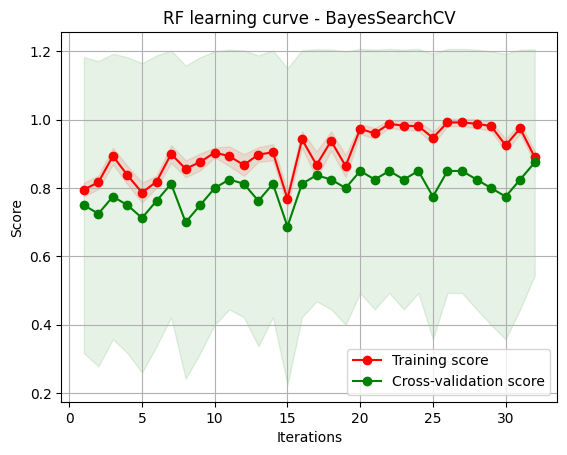

In [21]:
results_cv2 = pd.DataFrame(RF_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "RF learning curve - BayesSearchCV")
# results_cv2.head()

In [84]:
results_cv2 = pd.DataFrame(RF_bayes_search.cv_results_)
best_params = pd.DataFrame(results_cv2[results_cv2.index.isin([RF_bayes_search.best_index_])])

best_params[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]

,mean_test_score,std_test_score,mean_train_score,std_train_score
31,0.875,0.330719,0.890032,0.018189


In [22]:
results.shape

(32, 178)

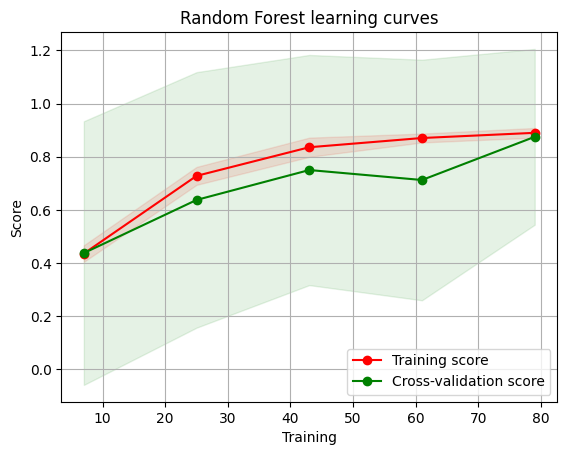

In [23]:
g = plot_learning_curve(RF_best,"Random Forest learning curves",X_train, y_train_enc,cv=cv)

In [24]:
filename_vot = './models/RF_best_bayes.sav'
joblib.dump(RF_best, filename_vot)

['./models/RF_best_bayes.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.77      0.91      0.83        11
           2       1.00      0.50      0.67         4

    accuracy                           0.85        27
   macro avg       0.90      0.78      0.81        27
weighted avg       0.87      0.85      0.85        27

Gini:  [0.85       0.72159091 0.5       ]
ROC AUC::  [0.925      0.86079545 0.75      ]


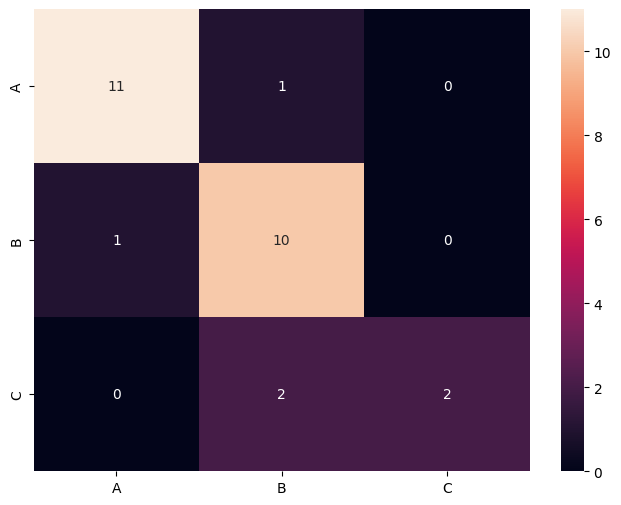

In [25]:
fit_and_print(RF_best, X_test)

### Support Vector Machine

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [32]:
SVM = SVC(random_state = 242, probability=True)
cv = LeaveOneOut()

SVM_search_space = {
        'gamma': Real(0.01, 10, prior='uniform'), 
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']), 
        'C': Real(0.01, 10, prior='uniform')
    }


In [33]:
SVM_bayes_search = BayesSearchCV(SVM, SVM_search_space, n_iter=32, return_train_score = True,# specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 101, optimizer_kwargs = {'base_estimator': 'GP'} )

inicio = time.time()
SVM_bayes_search.fit(X_train, y_train_enc) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(SVM_bayes_search.best_score_)
SVM_best = SVM_bayes_search.best_estimator_
print(SVM_bayes_search.best_estimator_)
print(SVM_bayes_search.best_params_)

time train
56.23202180862427
Acc
0.8125
SVC(C=10.0, gamma=0.6062987866039775, probability=True, random_state=242)
OrderedDict([('C', 10.0), ('gamma', 0.6062987866039775), ('kernel', 'rbf')])


In [28]:
# SVM_bayes_search.optimizer_results_

In [34]:
results = pd.DataFrame(SVM_bayes_search.cv_results_).sort_values(by = 'rank_test_score')
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,split50_test_score,split51_test_score,split52_test_score,split53_test_score,split54_test_score,split55_test_score,split56_test_score,split57_test_score,split58_test_score,split59_test_score,split60_test_score,split61_test_score,split62_test_score,split63_test_score,split64_test_score,split65_test_score,split66_test_score,split67_test_score,split68_test_score,split69_test_score,split70_test_score,split71_test_score,split72_test_score,split73_test_score,split74_test_score,split75_test_score,split76_test_score,split77_test_score,split78_test_score,split79_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,split15_train_score,split16_train_score,split17_train_score,split18_train_score,split19_train_score,split20_train_score,split21_train_score,split22_train_score,split23_train_score,split24_train_score,split25_train_score,split26_train_score,split27_train_score,split28_train_score,split29_train_score,split30_train_score,split31_train_score,split32_train_score,split33_train_score,split34_train_score,split35_train_score,split36_train_score,split37_train_score,split38_train_score,split39_train_score,split40_train_score,split41_train_score,split42_train_score,split43_train_score,split44_train_score,split45_train_score,split46_train_score,split47_train_score,split48_train_score,split49_train_score,split50_train_score,split51_train_score,split52_train_score,split53_train_score,split54_train_score,split55_train_score,split56_train_score,split57_train_score,split58_train_score,split59_train_score,split60_train_score,split61_train_score,split62_train_score,split63_train_score,split64_train_score,split65_train_score,split66_train_score,split67_train_score,split68_train_score,split69_train_score,split70_train_score,split71_train_score,split72_train_score,split73_train_score,split74_train_score,split75_train_score,split76_train_score,split77_train_score,split78_train_score,split79_train_score,mean_train_score,std_train_score,rank_train_score
29,0.010039,0.010097,0.001522,0.000544,10.0,0.576703,rbf,"{'C': 10.0, 'gamma': 0.5767026771977956, 'kern...",1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.8125,0.390312,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\master\\Lib\\site-packages\\matplotlib\\pyplot.py'>

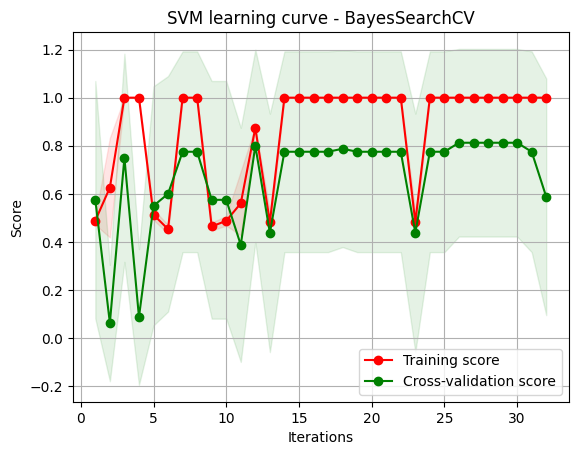

In [35]:
results_cv2 = pd.DataFrame(SVM_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "SVM learning curve - BayesSearchCV")

In [36]:
results_cv2 = pd.DataFrame(SVM_bayes_search.cv_results_)
best_params = pd.DataFrame(results_cv2[results_cv2.index.isin([SVM_bayes_search.best_index_])])

best_params[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]

,mean_test_score,std_test_score,mean_train_score,std_train_score
25,0.8125,0.390312,1.0,0.0


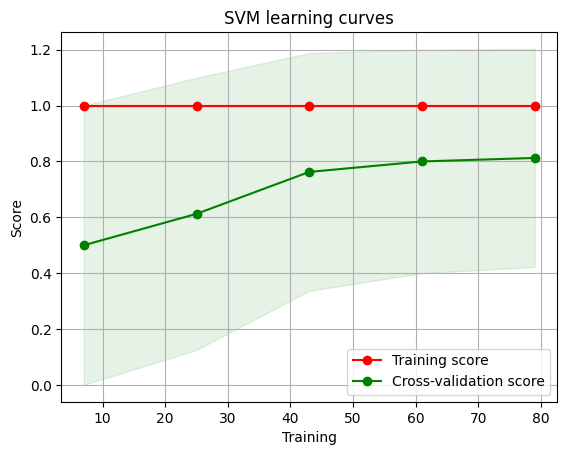

In [37]:
g = plot_learning_curve(SVM_best,"SVM learning curves",X_train,y_train_enc, cv=cv)

In [32]:
filename_vot = './models/SVM_best_bayes.sav'
joblib.dump(SVM_best, filename_vot)

['./models/SVM_best_bayes.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.73      1.00      0.85        11
           2       1.00      0.25      0.40         4

    accuracy                           0.85        27
   macro avg       0.91      0.72      0.73        27
weighted avg       0.89      0.85      0.83        27

Gini:  [0.91666667 0.75       0.25      ]
ROC AUC::  [0.95833333 0.875      0.625     ]


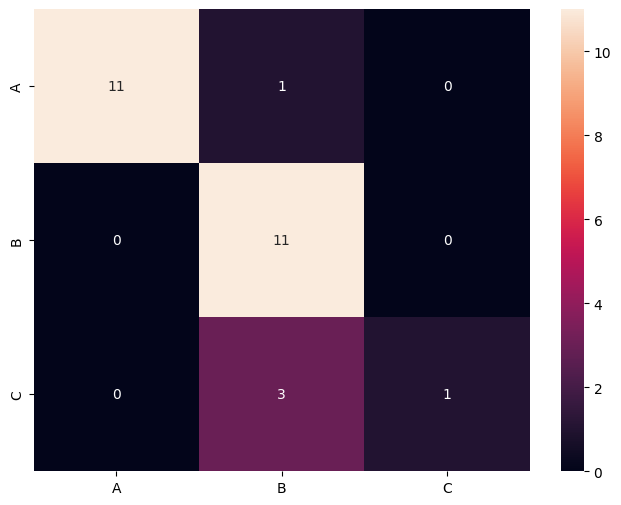

In [38]:
fit_and_print(SVM_best, X_test)

### Logistic Regression 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [18]:
LR = LogisticRegression(random_state=25)
cv = LeaveOneOut()

LR_search_space = {
    'solver': Categorical(['saga']),  
    'penalty': Categorical(['l1','l2']),
    'tol': Real(1e-5, 1e-3, 'uniform'),
    'C': Real(1e-3, 10, 'uniform'),
    'fit_intercept': Categorical([True, False]),
    'class_weight': Categorical(['balanced']),
    'multi_class': Categorical(['multinomial'])
}

In [19]:
LR_bayes_search = BayesSearchCV(LR, LR_search_space, n_iter=32, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 102, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
LR_bayes_search.fit(X_train, y_train_enc) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(LR_bayes_search.best_score_)
LR_best = LR_bayes_search.best_estimator_
print(LR_bayes_search.best_estimator_)
print(LR_bayes_search.best_params_)

time train
60.82428503036499
Acc
0.7875
LogisticRegression(C=3.8553146696590823, class_weight='balanced',
                   multi_class='multinomial', random_state=25, solver='saga',
                   tol=1e-05)
OrderedDict([('C', 3.8553146696590823), ('class_weight', 'balanced'), ('fit_intercept', True), ('multi_class', 'multinomial'), ('penalty', 'l2'), ('solver', 'saga'), ('tol', 1e-05)])


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\master\\Lib\\site-packages\\matplotlib\\pyplot.py'>

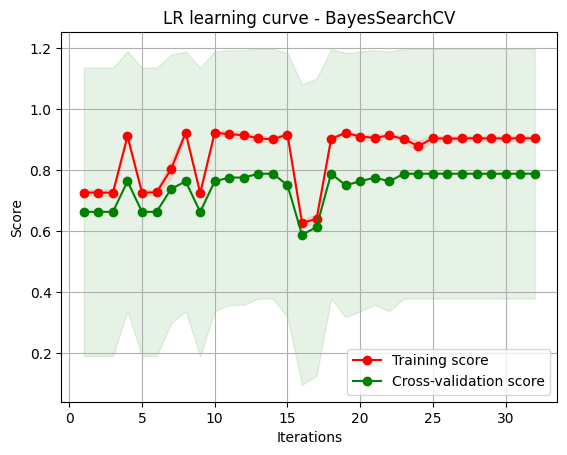

In [20]:
results_cv2 = pd.DataFrame(LR_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "LR learning curve - BayesSearchCV")

In [21]:
results_cv2 = pd.DataFrame(LR_bayes_search.cv_results_)
best_params = pd.DataFrame(results_cv2[results_cv2.index.isin([LR_bayes_search.best_index_])])

best_params[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]

,mean_test_score,std_test_score,mean_train_score,std_train_score
12,0.7875,0.409077,0.903481,0.008343


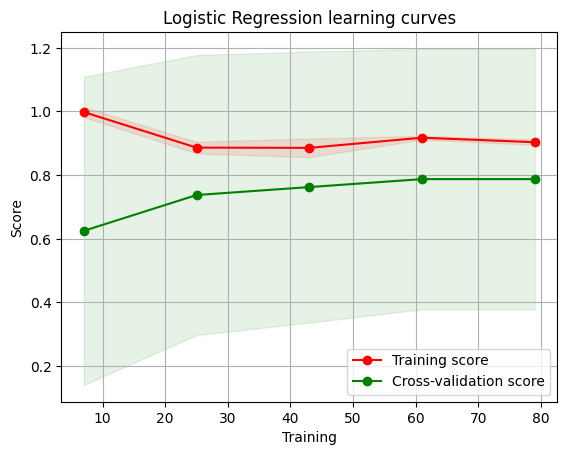

In [22]:
g = plot_learning_curve(LR_best,"Logistic Regression learning curves",X_train, y_train_enc, cv=cv)

In [24]:
filename_vot = './models/LR_best_bayes.sav'
joblib.dump(LR_best, filename_vot)

['./models/LR_best_bayes.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.77      0.91      0.83        11
           2       0.67      0.50      0.57         4

    accuracy                           0.85        27
   macro avg       0.81      0.78      0.79        27
weighted avg       0.86      0.85      0.85        27

Gini:  [0.91666667 0.72159091 0.45652174]
ROC AUC::  [0.95833333 0.86079545 0.72826087]


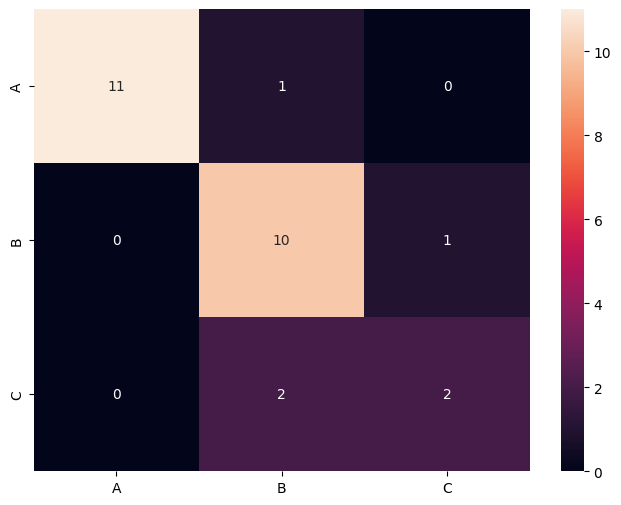

In [23]:
fit_and_print(LR_best, X_test)

### KNN

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [46]:
KNN = KNeighborsClassifier()
cv = LeaveOneOut()

KNN_search_space = {
    'weights': Categorical(['uniform', 'distance']),  
    'n_neighbors': Integer(3, 8, 'uniform'), 
    'p': Integer(1, 3, 'uniform'), 
    'metric': Categorical(['minkowski']), 
    'leaf_size': Integer(10, 20, prior='uniform')}

In [47]:
KNN_bayes_search = BayesSearchCV(KNN, KNN_search_space, n_iter=32, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 104, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
KNN_bayes_search.fit(X_train, y_train_enc) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(KNN_bayes_search.best_score_)
KNN_best = KNN_bayes_search.best_estimator_
print(KNN_bayes_search.best_estimator_)
print(KNN_bayes_search.best_params_)

time train
32.724825859069824
Acc
0.7875
KNeighborsClassifier(leaf_size=17, n_neighbors=4, weights='distance')
OrderedDict([('leaf_size', 17), ('metric', 'minkowski'), ('n_neighbors', 4), ('p', 2), ('weights', 'distance')])


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\master\\Lib\\site-packages\\matplotlib\\pyplot.py'>

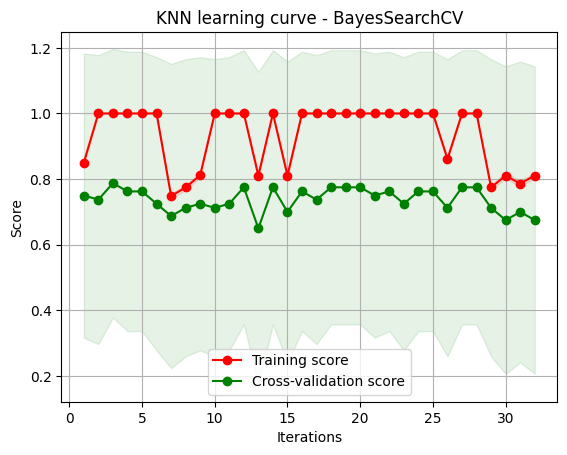

In [48]:
results_cv2 = pd.DataFrame(KNN_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "KNN learning curve - BayesSearchCV")

In [80]:
results_cv2 = pd.DataFrame(KNN_bayes_search.cv_results_)
best_params = pd.DataFrame(results_cv2[results_cv2.index.isin([KNN_bayes_search.best_index_])])

best_params[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]

,mean_test_score,std_test_score,mean_train_score,std_train_score
2,0.7875,0.409077,1.0,0.0


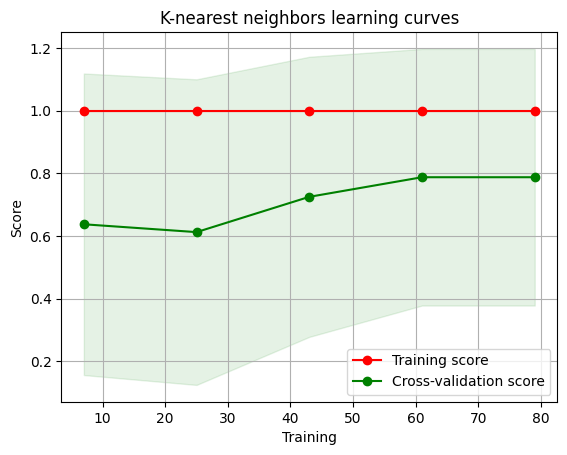

In [49]:
g = plot_learning_curve(KNN_best,"K-nearest neighbors learning curves", X_train, y_train_enc, cv=cv)

In [50]:
filename_vot = './models/KNN_best_bayes.sav'
joblib.dump(KNN_best, filename_vot)

['./models/KNN_best_bayes.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.67      0.73      0.70        11
           2       1.00      0.25      0.40         4

    accuracy                           0.74        27
   macro avg       0.82      0.63      0.65        27
weighted avg       0.77      0.74      0.72        27

Gini:  [0.71666667 0.47727273 0.25      ]
ROC AUC::  [0.85833333 0.73863636 0.625     ]


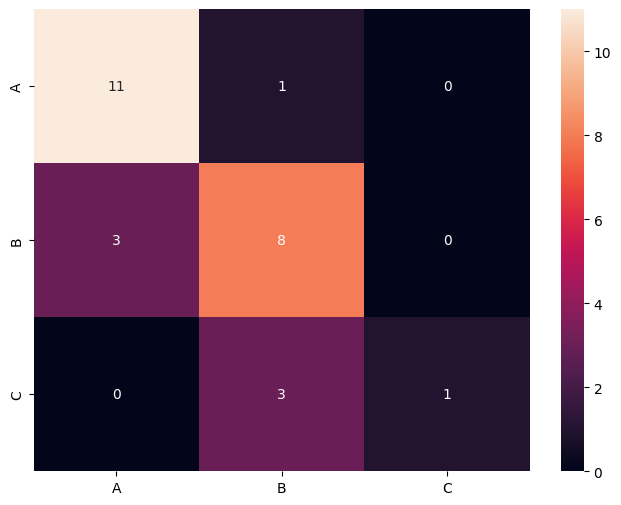

In [51]:
fit_and_print(KNN_best, X_test)

### GBM

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [30]:
GBM = GradientBoostingClassifier(random_state=32)
cv = LeaveOneOut()
GBM_search_space = {

        'max_depth': Integer(3, 5, prior='uniform'),
        'loss': Categorical(['log_loss']),
        'learning_rate' : Real(0.001, 0.05, prior='uniform') , 
        'n_estimators': Integer(5, 15, prior='uniform'),
        'criterion': Categorical(['friedman_mse', 'squared_error']),
        "max_features": Categorical(['sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10, prior='uniform'),
        "min_samples_split": Integer(2, 10, prior='uniform')
    }

In [31]:
GBM_bayes_search = BayesSearchCV(GBM, GBM_search_space, n_iter=32, return_train_score = True, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=cv, random_state = 106, optimizer_kwargs = {'base_estimator': 'GP'})

inicio = time.time()
GBM_bayes_search.fit(X_train, y_train_enc) # callback=on_step will print score after each iteration
fim = time.time()
print("time train")
print(fim - inicio)
print("Acc")
print(GBM_bayes_search.best_score_)
GBM_best = GBM_bayes_search.best_estimator_
print(GBM_bayes_search.best_estimator_)
print(GBM_bayes_search.best_params_)

time train
101.36890745162964
Acc
0.8375
GradientBoostingClassifier(learning_rate=0.05, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=9,
                           n_estimators=15, random_state=32)
OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.05), ('loss', 'log_loss'), ('max_depth', 3), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 9), ('n_estimators', 15)])


<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\master\\Lib\\site-packages\\matplotlib\\pyplot.py'>

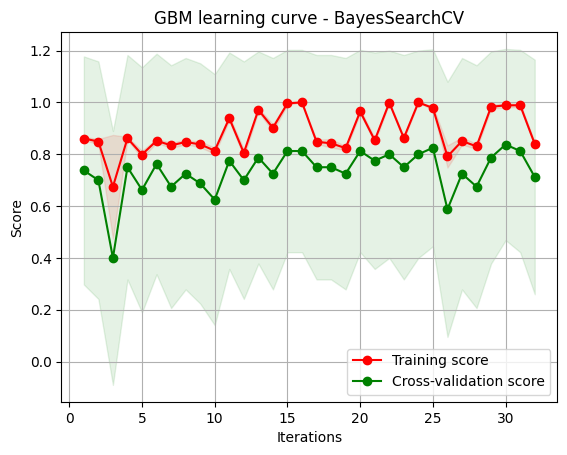

In [32]:
results_cv2 = pd.DataFrame(GBM_bayes_search.cv_results_)
results_cv2  = results_cv2[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]
plot_learning_curve_cross_validation(results_cv2, "GBM learning curve - BayesSearchCV")

In [33]:
results_cv2 = pd.DataFrame(GBM_bayes_search.cv_results_)
best_params = pd.DataFrame(results_cv2[results_cv2.index.isin([GBM_bayes_search.best_index_])])

best_params[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']]

,mean_test_score,std_test_score,mean_train_score,std_train_score
29,0.8375,0.368909,0.988766,0.008251


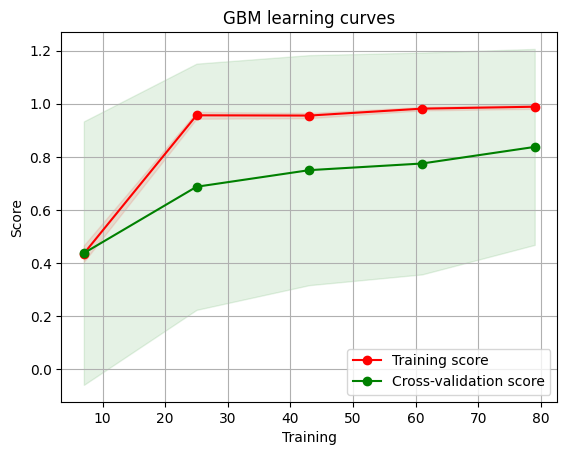

In [34]:
g = plot_learning_curve(GBM_best,"GBM learning curves",X_train, y_train_enc,cv=cv)

In [35]:
filename_vot = './models/GBM_best_bayes.sav'
joblib.dump(GBM_best, filename_vot)

['./models/GBM_best_bayes.sav']

Validation

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.73      1.00      0.85        11
           2       1.00      0.25      0.40         4

    accuracy                           0.85        27
   macro avg       0.91      0.72      0.73        27
weighted avg       0.89      0.85      0.83        27

Gini:  [0.91666667 0.75       0.25      ]
ROC AUC::  [0.95833333 0.875      0.625     ]


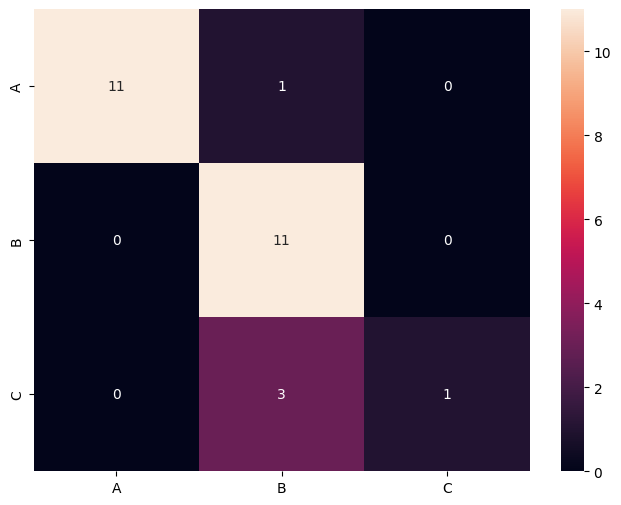

In [36]:
fit_and_print(GBM_best, X_test)